In [96]:
import numpy as np
import seaborn as sns
from seaborn import lmplot, boxplot
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tabulate import tabulate
import warnings

df = pd.read_csv('diamonds.csv', sep=',', encoding='utf-8')

# Eliminar la columna 'Unnamed: 0' si existe
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

# ANÁLISIS EXPLORATORIO

In [133]:
df.head(3)

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31


In [135]:
df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


El análisis descriptivo de los datos numéricos revela varias ideas clave sobre las características de los diamantes:

Carat (Peso): Los diamantes en el conjunto de datos varían en peso desde 0.2 hasta 5.01 quilates, con un peso promedio de 0.798 quilates. La desviación estándar de 0.474 indica una dispersión considerable en los pesos de los diamantes.

Depth (Profundidad): La profundidad porcentual total de los diamantes oscila entre el 43% y el 79%, con un promedio del 61.75%. La desviación estándar de 1.43 sugiere una variación moderada en la profundidad.

Table (Ancho de la Tabla): El ancho de la tabla varía del 43% al 95%, con un promedio del 57.46%. La desviación estándar de 2.23 indica una amplia gama de anchos de tabla en los diamantes.


Price (Precio): Los precios de los diamantes van desde $326 hasta $18,823, con un precio promedio de $3,932.80. La desviación estándar de $3,989.44 revela una gran dispersión en los precios, lo que sugiere una amplia variedad de calidades y características en los diamantes.

Dimensiones (x, y, z): Las dimensiones de los diamantes (largo, ancho y profundidad) también muestran una variación considerable. Es interesante notar que la dimensión 'y' (ancho) tiene un valor máximo atípico de 58.9 mm, lo que podría indicar un error de datos o un diamante con una forma inusual.

In [77]:
df.dtypes

carat       float64
cut        category
color      category
clarity    category
depth       float64
table       float64
price         int64
x           float64
y           float64
z           float64
dtype: object

Variables Numéricas: Las columnas carat, depth, table, price, x, y, y z son numéricas (float64 para valores decimales e int64 para valores enteros). Estas variables se pueden utilizar directamente para cálculos y análisis estadísticos.
Variables Categóricas: Las columnas cut, color, y clarity son de tipo objeto, lo que sugiere que contienen valores categóricos o de texto. Estas variables requerirán codificación o transformación antes de poder ser utilizadas en modelos de aprendizaje automático.

| Variable   |   Media |   Mediana |   Moda |
|:-----------|--------:|----------:|-------:|
| carat      |   0.798 |      0.7  |   0.3  |
| depth      |  61.749 |     61.8  |  62    |
| table      |  57.457 |     57    |  56    |
| x          |   5.731 |      5.7  |   4.37 |
| y          |   5.735 |      5.71 |   4.34 |
| z          |   3.539 |      3.53 |   2.7  |


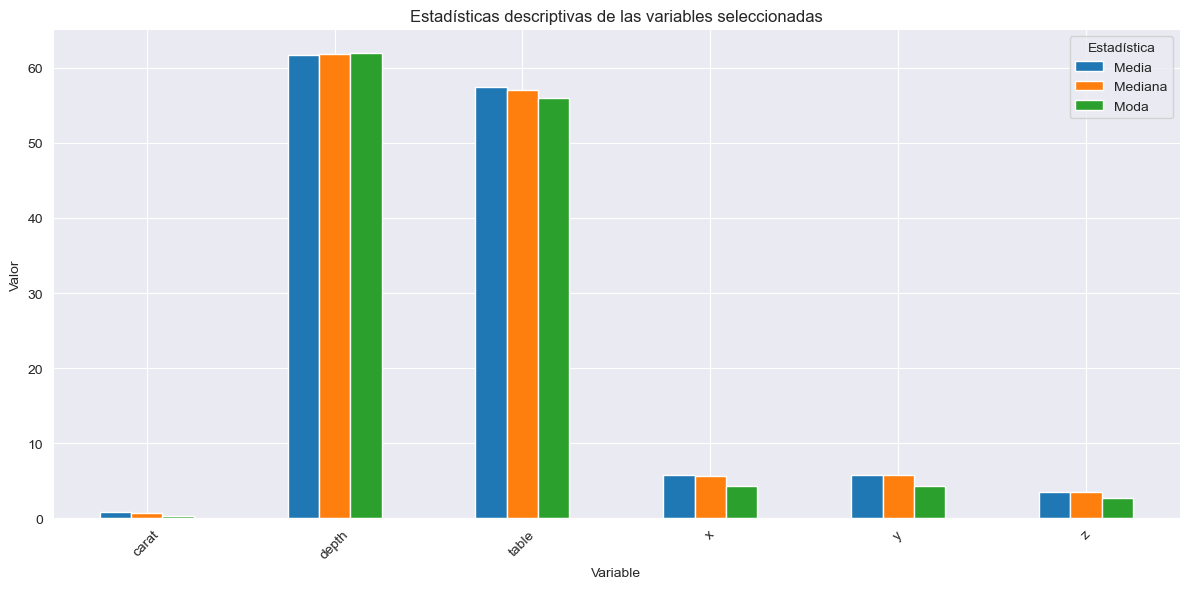

In [139]:
# Seleccionar sólo las columnas numéricas, excluyendo 'price'
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
numeric_columns = numeric_columns[numeric_columns != 'price']
filtered_df = df[numeric_columns]


mean = filtered_df.mean().reset_index().round(3)
median = filtered_df.median().reset_index()
mode = filtered_df.mode().iloc[0].reset_index()

# Renombrar columnas
mean = mean.rename(columns={'index':'Variable',0:'Valor'})
median = median.rename(columns={'index':'Variable',0:'Valor'})
mode = mode.rename(columns={'index':'Variable',0:'Valor'})

mean['Statistic'] = 'Media'
median['Statistic'] = 'Mediana'
mode['Statistic'] = 'Moda'

merged_df = pd.concat([mean, median, mode])

pivoted_df = merged_df.pivot(index='Variable', columns='Statistic', values='Valor').reset_index()

print(tabulate(pivoted_df, headers='keys', tablefmt='pipe', showindex=False))

# Graficar
fig, ax = plt.subplots(figsize=(12, 6))
pivoted_df.plot(kind='bar', ax=ax)
plt.xticks(range(len(pivoted_df)), pivoted_df['Variable'], rotation=45)
plt.ylabel('Valor')
plt.title('Estadísticas descriptivas de las variables seleccionadas')
plt.xlabel('Variable')
plt.legend(title='Estadística')
plt.tight_layout()
plt.show()

In [140]:
# Filter the DataFrame to only include the columns: carat, depth, table, price, x, y, and z
columns = ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']
filtered_df = df[columns]

# Calculate the minimum, 25th percentile, median (50th percentile), 75th percentile, and maximum values for each of these columns.
stats_dict = {}
for col in columns:
    stats_dict[col] = [
        filtered_df[col].min(),
        filtered_df[col].quantile(0.25),
        filtered_df[col].median(),
        filtered_df[col].quantile(0.75),
        filtered_df[col].max()
    ]

# Create a DataFrame from the dictionary, with the index being the statistics names ('Minimo', 'Quartil 25', 'Quartil 50', 'Quartil 75', 'Maximo').
stats_df = pd.DataFrame(stats_dict, index=['Minimo', 'Quartil 25', 'Quartil 50', 'Quartil 75', 'Maximo'])

# Print the DataFrame in markdown format
print(tabulate(stats_df, headers='keys', tablefmt='pipe', showindex=True))

|            |   carat |   depth |   table |    price |     x |     y |     z |
|:-----------|--------:|--------:|--------:|---------:|------:|------:|------:|
| Minimo     |    0.2  |    43   |      43 |   326    |  0    |  0    |  0    |
| Quartil 25 |    0.4  |    61   |      56 |   950    |  4.71 |  4.72 |  2.91 |
| Quartil 50 |    0.7  |    61.8 |      57 |  2401    |  5.7  |  5.71 |  3.53 |
| Quartil 75 |    1.04 |    62.5 |      59 |  5324.25 |  6.54 |  6.54 |  4.04 |
| Maximo     |    5.01 |    79   |      95 | 18823    | 10.74 | 58.9  | 31.8  |


|            |   carat |   depth |   table |     x |     y |     z |
|:-----------|--------:|--------:|--------:|------:|------:|------:|
| Minimo     |    0.2  |    43   |      43 |  0    |  0    |  0    |
| Quartil 25 |    0.4  |    61   |      56 |  4.71 |  4.72 |  2.91 |
| Quartil 50 |    0.7  |    61.8 |      57 |  5.7  |  5.71 |  3.53 |
| Quartil 75 |    1.04 |    62.5 |      59 |  6.54 |  6.54 |  4.04 |
| Maximo     |    5.01 |    79   |      95 | 10.74 | 58.9  | 31.8  |


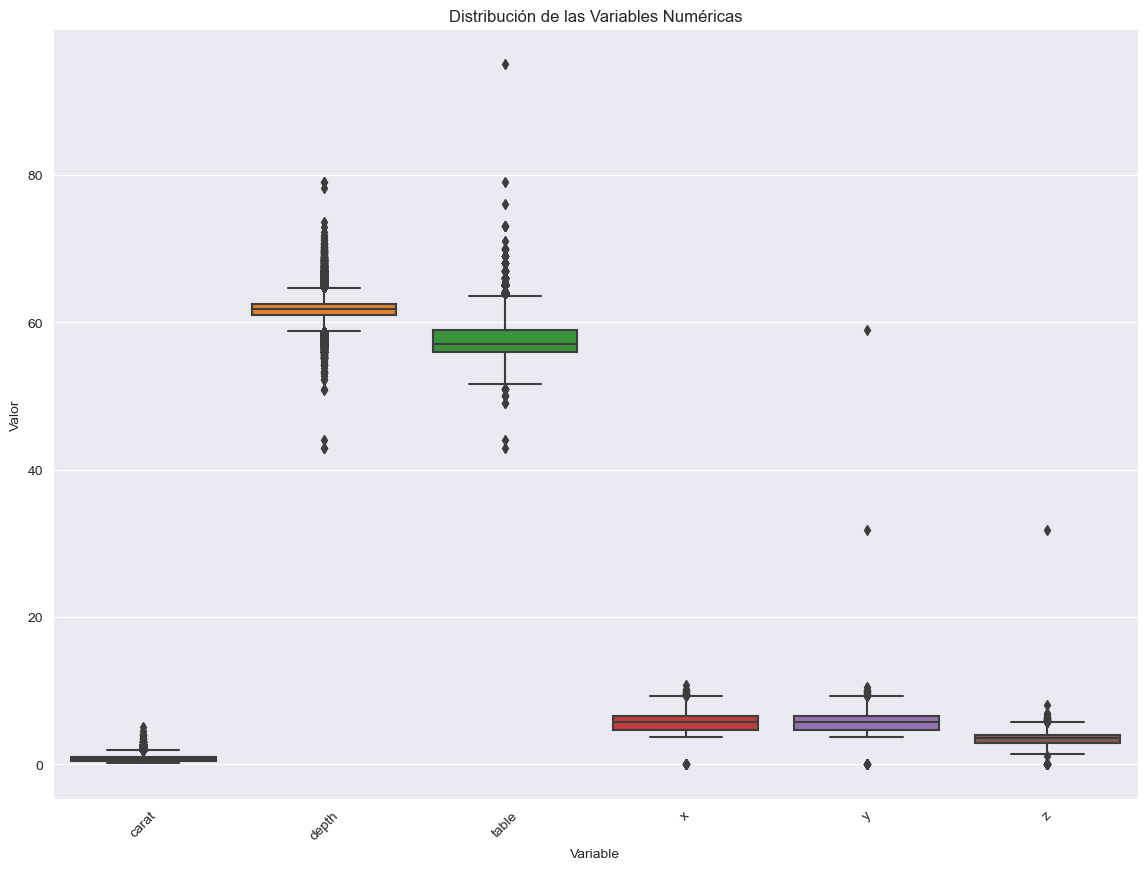

In [141]:
# Seleccionar sólo las columnas numéricas, excluyendo 'price'
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
numeric_columns = numeric_columns[numeric_columns != 'price']
filtered_df = df[numeric_columns]

# Calcular los estadísticos mínimos, cuartiles y máximos
stats_dict = {}
for col in numeric_columns:
    stats_dict[col] = [
        filtered_df[col].min(),
        filtered_df[col].quantile(0.25),
        filtered_df[col].median(),
        filtered_df[col].quantile(0.75),
        filtered_df[col].max()
    ]

# Crear un DataFrame con los estadísticos
stats_df = pd.DataFrame(stats_dict, index=['Minimo', 'Quartil 25', 'Quartil 50', 'Quartil 75', 'Maximo'])

# Imprimir el DataFrame en formato markdown
print(tabulate(stats_df, headers='keys', tablefmt='pipe', showindex=True))

# Graficar boxplots para visualizar la distribución de cada variable
plt.figure(figsize=(14, 10))
sns.boxplot(data=filtered_df)
plt.title('Distribución de las Variables Numéricas')
plt.xlabel('Variable')
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.show()

| Variable   |   Desviación Estándar |   Rango Interquartil |
|:-----------|----------------------:|---------------------:|
| carat      |              0.474011 |                 0.64 |
| depth      |              1.43262  |                 1.5  |
| table      |              2.23449  |                 3    |
| x          |              1.12176  |                 1.83 |
| y          |              1.14213  |                 1.82 |
| z          |              0.705699 |                 1.13 |


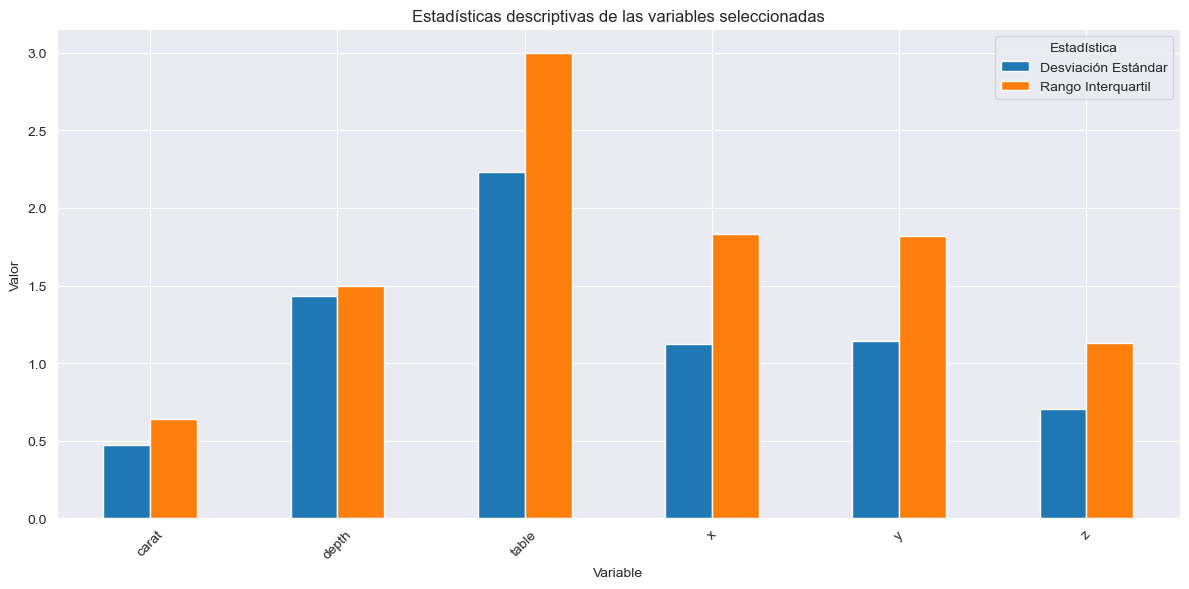

In [142]:
# Seleccionar sólo las columnas numéricas, excluyendo 'price'
numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
numeric_columns = numeric_columns[numeric_columns != 'price']
filtered_df = df[numeric_columns]

std = filtered_df.std().reset_index()
quartiles = filtered_df.quantile([0.25, 0.75])

iqr = quartiles.loc[0.75] - quartiles.loc[0.25]

std = std.rename(columns={'index':'Variable', 0:'Valor'})
iqr = iqr.reset_index().rename(columns={'index':'Variable', 0:'Valor'})

std['Statistic'] = 'Desviación Estándar'
iqr['Statistic'] = 'Rango Interquartil'

merged_df = pd.concat([std, iqr])

pivoted_df = merged_df.pivot(index='Variable', columns='Statistic', values='Valor').reset_index()

print(tabulate(pivoted_df, headers='keys', tablefmt='pipe', showindex=False))

# Graficar
fig, ax = plt.subplots(figsize=(12, 6))
pivoted_df.plot(kind='bar', ax=ax)
plt.xticks(range(len(pivoted_df)), pivoted_df['Variable'], rotation=45)
plt.ylabel('Valor')
plt.title('Estadísticas descriptivas de las variables seleccionadas')
plt.xlabel('Variable')
plt.legend(title='Estadística')
plt.tight_layout()
plt.show()

In [51]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
carat,53940.0,0.797940,0.474011,0.2,0.40,0.70,1.04,5.01
depth,53940.0,61.749405,1.432621,43.0,61.00,61.80,62.50,79.00
table,53940.0,57.457184,2.234491,43.0,56.00,57.00,59.00,95.00
price,53940.0,3932.799722,3989.439738,326.0,950.00,2401.00,5324.25,18823.00
x,53940.0,5.731157,1.121761,0.0,4.71,5.70,6.54,10.74
y,53940.0,5.734526,1.142135,0.0,4.72,5.71,6.54,58.90
z,53940.0,3.538734,0.705699,0.0,2.91,3.53,4.04,31.80


Correlation:
|       |   carat |   depth |   table |   price |      x |      y |     z |
|:------|--------:|--------:|--------:|--------:|-------:|-------:|------:|
| carat |   1     |   0.028 |   0.182 |   0.922 |  0.975 |  0.952 | 0.953 |
| depth |   0.028 |   1     |  -0.296 |  -0.011 | -0.025 | -0.029 | 0.095 |
| table |   0.182 |  -0.296 |   1     |   0.127 |  0.195 |  0.184 | 0.151 |
| price |   0.922 |  -0.011 |   0.127 |   1     |  0.884 |  0.865 | 0.861 |
| x     |   0.975 |  -0.025 |   0.195 |   0.884 |  1     |  0.975 | 0.971 |
| y     |   0.952 |  -0.029 |   0.184 |   0.865 |  0.975 |  1     | 0.952 |
| z     |   0.953 |   0.095 |   0.151 |   0.861 |  0.971 |  0.952 | 1     |


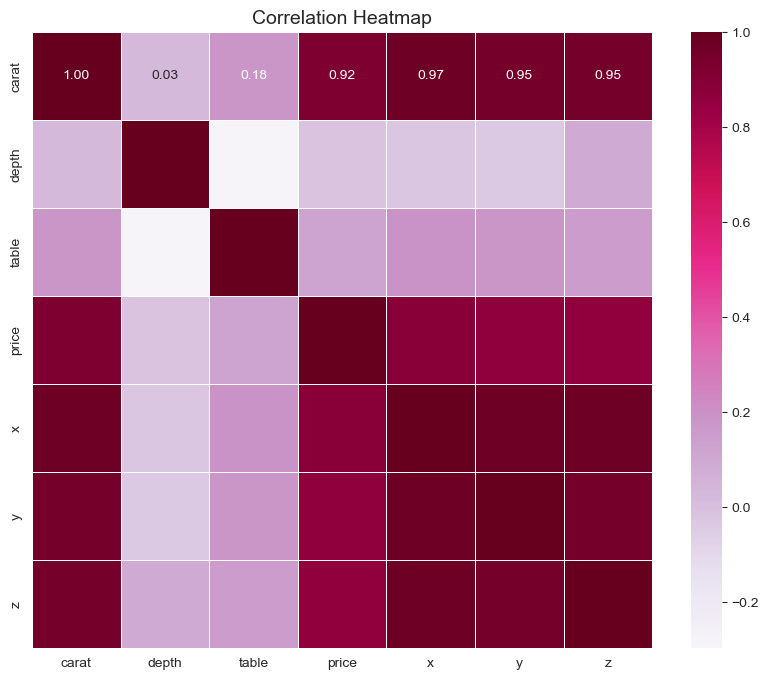

In [143]:
# Calculate the correlation matrix
correlation_matrix = df.corr(numeric_only=True).round(3)

# Print the correlation matrix
print("Correlation:")
print(tabulate(correlation_matrix, headers='keys', tablefmt='pipe', showindex=True))

# Create the heatmap using seaborn
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(correlation_matrix, annot=True, cmap="PuRd", fmt=".2f", linewidths=.5)

# Add title
plt.title('Correlation Heatmap', fontsize=14)
plt.show()

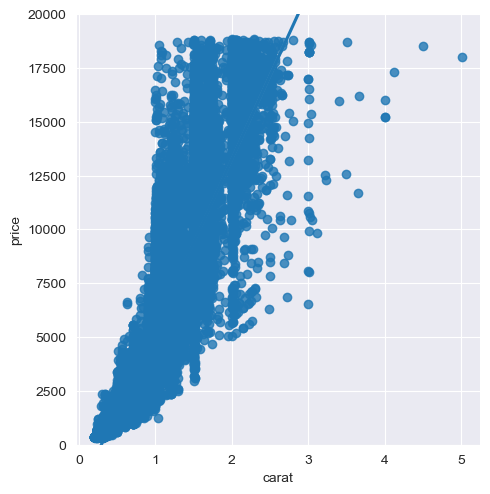

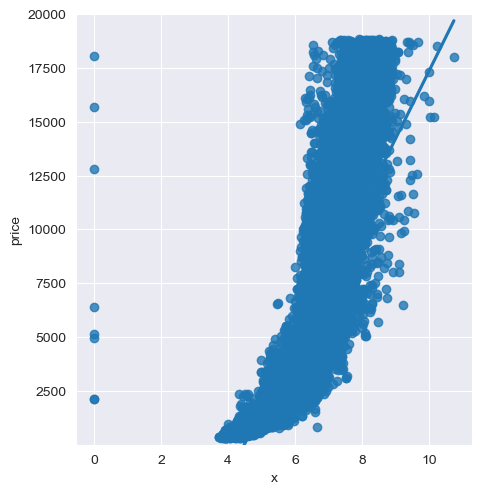

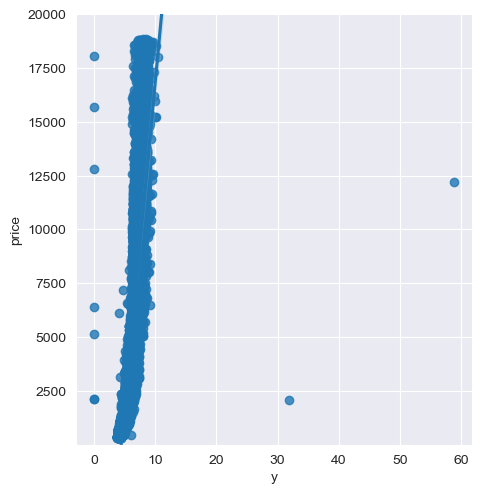

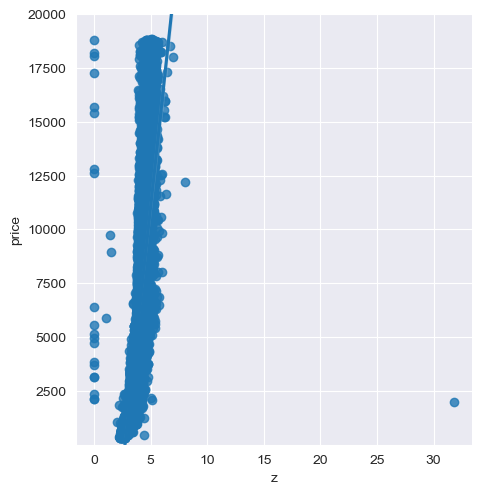

In [55]:
# Crear gráficos de regresión lineal con el rango de precio ajustado
lmplot(x='carat', y='price', data=df).set(ylim=(0, 20000))
lmplot(x='x', y='price', data=df).set(ylim=(10, 20000))
lmplot(x='y', y='price', data=df).set(ylim=(10, 20000))
lmplot(x='z', y='price', data=df).set(ylim=(10, 20000))

# Mostrar los gráficos
plt.show()


|       |   carat |   depth |   table |   price |      x |      y |     z |
|:------|--------:|--------:|--------:|--------:|-------:|-------:|------:|
| carat |   1     |   0.028 |   0.182 |   0.922 |  0.975 |  0.952 | 0.953 |
| depth |   0.028 |   1     |  -0.296 |  -0.011 | -0.025 | -0.029 | 0.095 |
| table |   0.182 |  -0.296 |   1     |   0.127 |  0.195 |  0.184 | 0.151 |
| price |   0.922 |  -0.011 |   0.127 |   1     |  0.884 |  0.865 | 0.861 |
| x     |   0.975 |  -0.025 |   0.195 |   0.884 |  1     |  0.975 | 0.971 |
| y     |   0.952 |  -0.029 |   0.184 |   0.865 |  0.975 |  1     | 0.952 |
| z     |   0.953 |   0.095 |   0.151 |   0.861 |  0.971 |  0.952 | 1     |


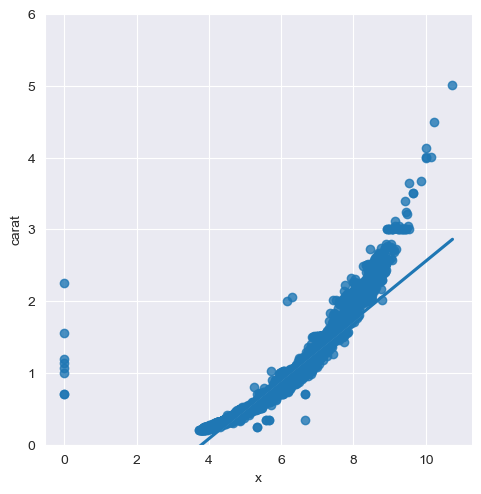

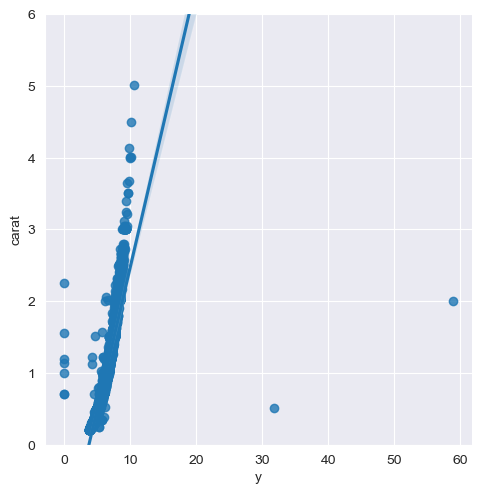

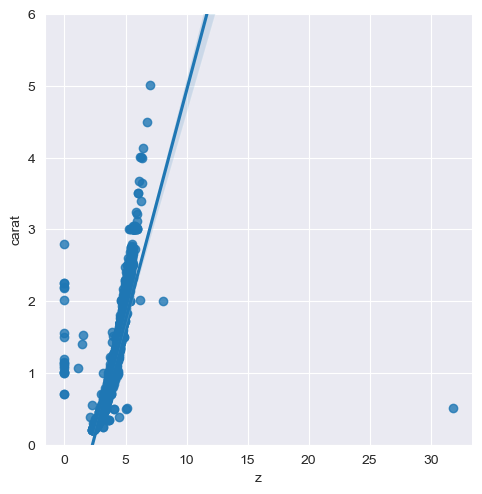

In [144]:
# Calcular la matriz de correlación
correlation_matrix = df.corr(numeric_only=True).round(3)
print(tabulate(correlation_matrix, headers='keys', tablefmt='pipe', showindex=True))

# Crear gráficos de regresión lineal con el rango de precio ajustado

lmplot(x='x', y='carat', data=df).set(ylim=(0, 6))
lmplot(x='y', y='carat', data=df).set(ylim=(0, 6))
lmplot(x='z', y='carat', data=df).set(ylim=(0, 6))

# Mostrar los gráficos
plt.show()

<Axes: xlabel='price', ylabel='carat'>

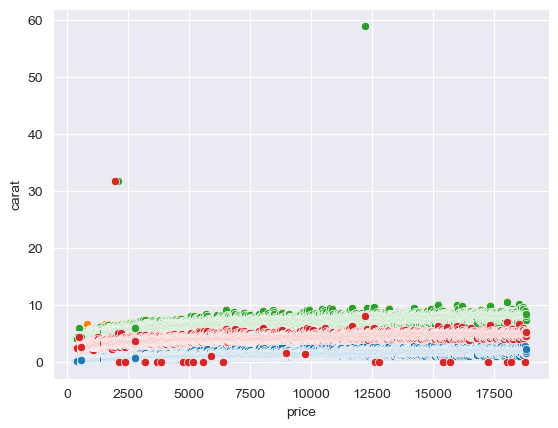

In [58]:
sns.scatterplot(x=df.price , y=df.carat)
sns.scatterplot(x=df.price , y=df.x)
sns.scatterplot(x=df.price , y=df.y)
sns.scatterplot(x=df.price , y=df.z)

<Axes: xlabel='color', ylabel='price'>

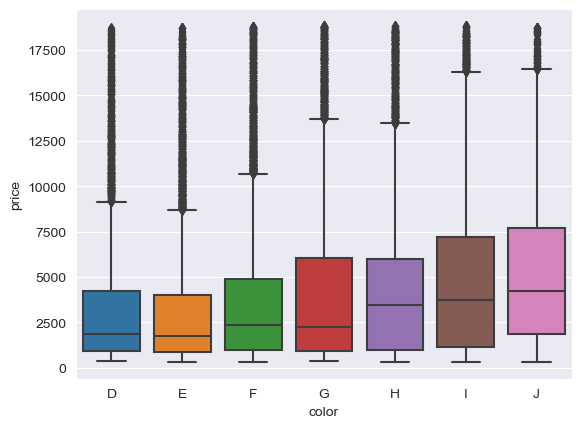

In [59]:
# Crear un gráfico de caja para cada variable cuantitativa
warnings.filterwarnings('ignore', category=FutureWarning)

boxplot(x="color", y="price",data=df)


<Axes: xlabel='cut', ylabel='price'>

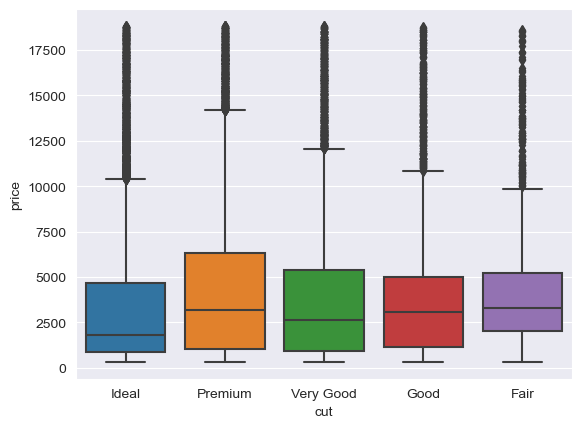

In [78]:
boxplot(x="cut", y="price", data=df)

<Axes: xlabel='clarity', ylabel='carat'>

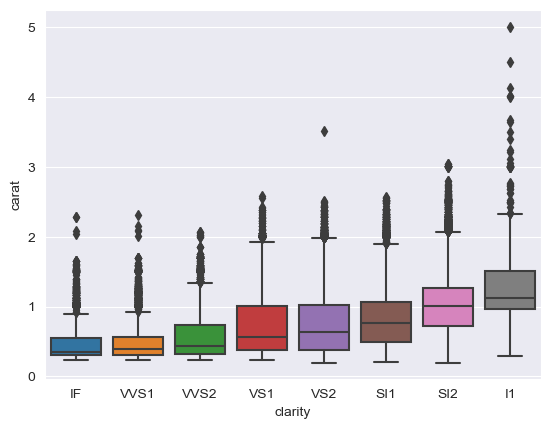

In [79]:
boxplot(x="clarity", y="carat", data=df)

In [148]:
zero = df.query('x==0 or y==0 or z==0')
print(tabulate(zero, headers='keys', tablefmt='pipe', showindex=False))

|   carat | cut       | color   | clarity   |   depth |   table |   price |    x |    y |   z |
|--------:|:----------|:--------|:----------|--------:|--------:|--------:|-----:|-----:|----:|
|    1    | Premium   | G       | SI2       |    59.1 |      59 |    3142 | 6.55 | 6.48 |   0 |
|    1.01 | Premium   | H       | I1        |    58.1 |      59 |    3167 | 6.66 | 6.6  |   0 |
|    1.1  | Premium   | G       | SI2       |    63   |      59 |    3696 | 6.5  | 6.47 |   0 |
|    1.01 | Premium   | F       | SI2       |    59.2 |      58 |    3837 | 6.5  | 6.47 |   0 |
|    1.5  | Good      | G       | I1        |    64   |      61 |    4731 | 7.15 | 7.04 |   0 |
|    1.07 | Ideal     | F       | SI2       |    61.6 |      56 |    4954 | 0    | 6.62 |   0 |
|    1    | Very Good | H       | VS2       |    63.3 |      53 |    5139 | 0    | 0    |   0 |
|    1.15 | Ideal     | G       | VS2       |    59.2 |      56 |    5564 | 6.88 | 6.83 |   0 |
|    1.14 | Fair      | G       | VS1   

In [82]:
len(df.query('carat>3'))

39549

In [83]:
len(df.query('carat>2'))

1889

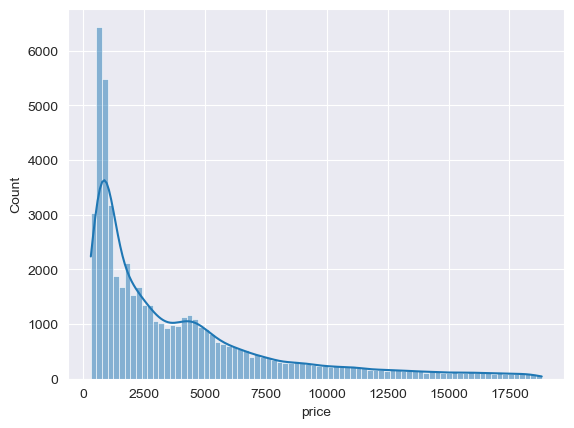

In [60]:
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.")
try:
    sns.histplot(df['price'], kde=True)
except Exception as e:
    print("Error:", e)

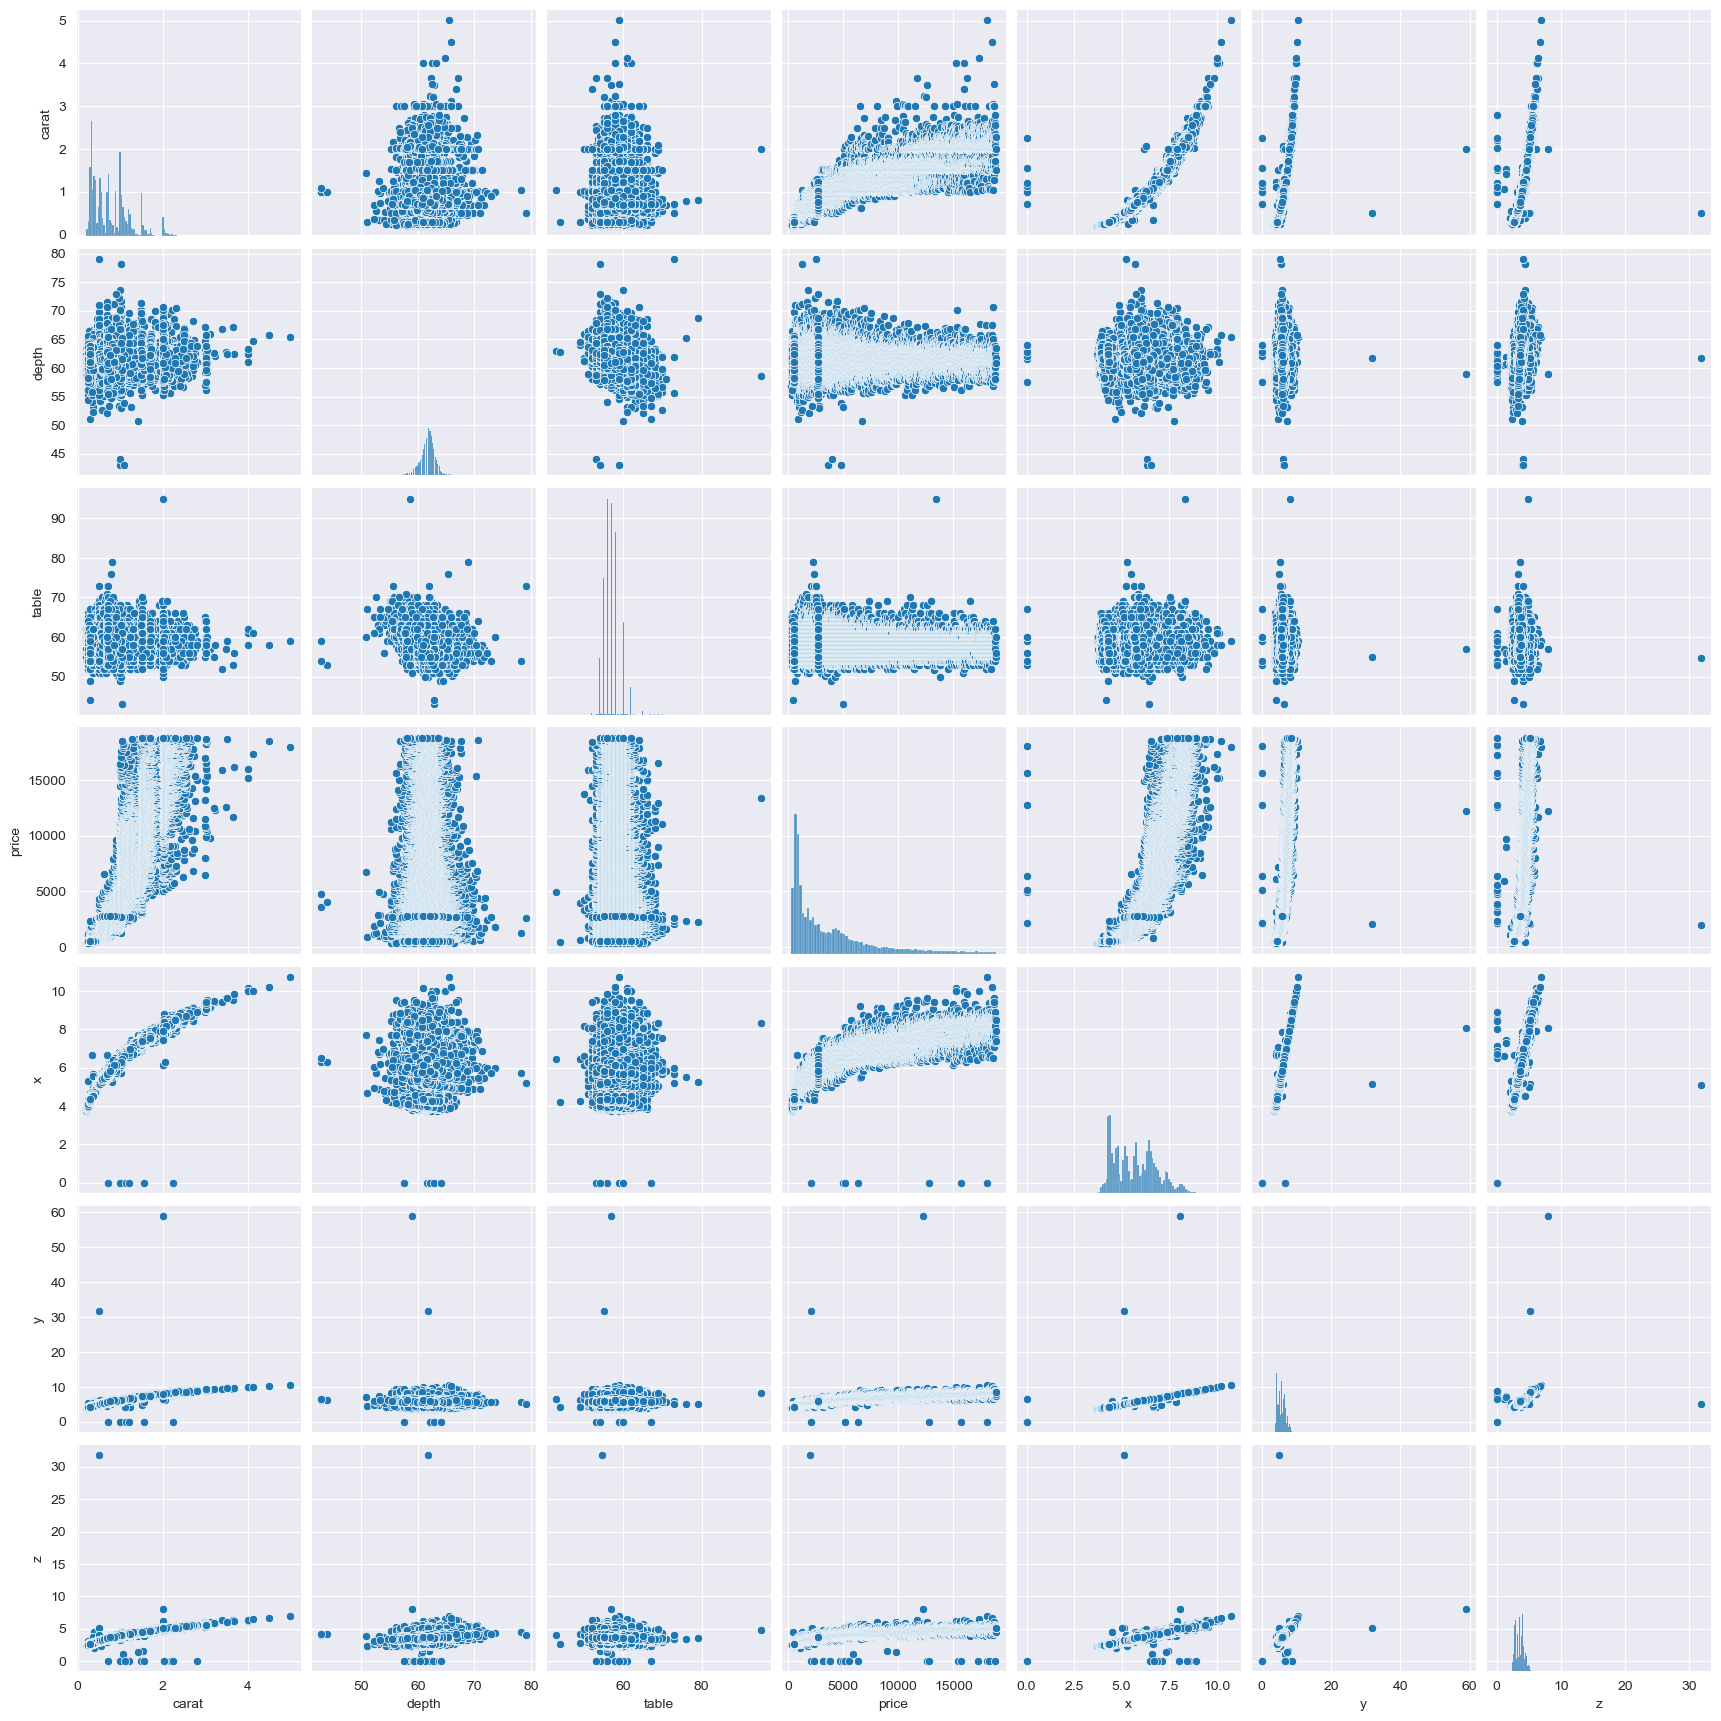

In [61]:
try:
    # Replace with NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    # Remove NaN Values (optional)
    df.dropna(inplace=True)

    sns.pairplot(df)
except Exception as e:
    print("Error:", e)

# TRANSFORMACIÓN DE DATOS

# Label Encoding 'cut'

In [153]:
# Copiar el DataFrame
diamonds_le = df.copy()

# Crear el objeto label_encoder para 'cut'
label_encoder_cut = preprocessing.LabelEncoder()

# Aplicar el label encoder a la columna 'cut'
diamonds_le['cut'] = label_encoder_cut.fit_transform(diamonds_le['cut'])

# Mostrar los valores únicos de la columna codificada 'cut'
print("Valores únicos para 'cut':")
print(dict(zip(label_encoder_cut.classes_, label_encoder_cut.transform(label_encoder_cut.classes_))))
diamonds_le.head()

Valores únicos para 'cut':
{'Fair': 0, 'Good': 1, 'Ideal': 2, 'Premium': 3, 'Very Good': 4}


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,2,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,3,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,1,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,3,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,1,J,SI2,63.3,58.0,335,4.34,4.35,2.75


# Label Encoding 'cut' - One Hot Encoding 'color', 'clarity', 

In [132]:
# Identificar columnas cauntitativas a codificar
categorical_cols = ['price', 'carat', 'depth', 'table', 'x', 'y', 'z']

# Verificar si las columnas existen en el DataFrame
for col in categorical_cols:
    if col not in df.columns:
        raise ValueError(f"La columna '{col}' no existe en el DataFrame.")

# Copiar el DataFrame original
df_transformed = df.copy()

# Label Encoding para 'cut'
le = preprocessing.LabelEncoder()
df_transformed['cut'] = le.fit_transform(df_transformed['cut'])

# One-Hot Encoding para 'color' y 'clarity'
df_transformed = pd.get_dummies(df_transformed, columns=['color', 'clarity'], drop_first=True)

# Seleccionar solo las columnas codificadas
# Excluir las columnas originales no categóricas
original_cols = ['carat', 'depth', 'table', 'price', 'x', 'y', 'z']
encoded_cols = [col for col in df_transformed.columns if col not in original_cols]
df_transformed_only = df_transformed[encoded_cols].astype(float)

# Mostrar resultados
print("DataFrame transformado")
print("\nNombres de columnas del DataFrame transformado:")
df_transformed_only.head()

DataFrame transformado

Nombres de columnas del DataFrame transformado:


,cut,color_E,color_F,color_G,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,3.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [160]:
# Identificar columnas cauntitativas a codificar
categorical_cols = ['price', 'carat', 'depth', 'table', 'x', 'y', 'z']

# Verificar si las columnas existen en el DataFrame
for col in categorical_cols:
    if col not in df.columns:
        raise ValueError(f"La columna '{col}' no existe en el DataFrame.")

# Copiar el DataFrame original
df_transformed = df.copy()

# Label Encoding para 'cut'
le = preprocessing.LabelEncoder()
df_transformed['cut'] = le.fit_transform(df_transformed['cut'])

# One-Hot Encoding para 'color' y 'clarity'
df_transformed = pd.get_dummies(df_transformed, columns=['color', 'clarity'], drop_first=True)

# Seleccionar solo las columnas codificadas
encoded_cols = [col for col in df_transformed.columns]
df_transformed_only = df_transformed[encoded_cols].astype(float)

# Mostrar resultados
print("\nNombres de columnas del DataFrame:")
print(df_transformed_only.columns.tolist())

# Mostrar resultados
print("DataFrame transformado:\n")
df_transformed_only.head()




Nombres de columnas del DataFrame:
['carat', 'cut', 'depth', 'table', 'price', 'x', 'y', 'z', 'color_E', 'color_F', 'color_G', 'color_H', 'color_I', 'color_J', 'clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1', 'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2']
DataFrame transformado:



,carat,cut,depth,table,price,x,y,z,color_E,color_F,...,color_H,color_I,color_J,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,2.0,61.5,55.0,326.0,3.95,3.98,2.43,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.21,3.0,59.8,61.0,326.0,3.89,3.84,2.31,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.23,1.0,56.9,65.0,327.0,4.05,4.07,2.31,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.29,3.0,62.4,58.0,334.0,4.20,4.23,2.63,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.31,1.0,63.3,58.0,335.0,4.34,4.35,2.75,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# PREPARACIÓN DE LOS DATOS